# Pipeline

## 1. Blocks cutting

### 1.1. Fetching data from OpenStreetMap. 
The step can be skipped, if the data already exists.

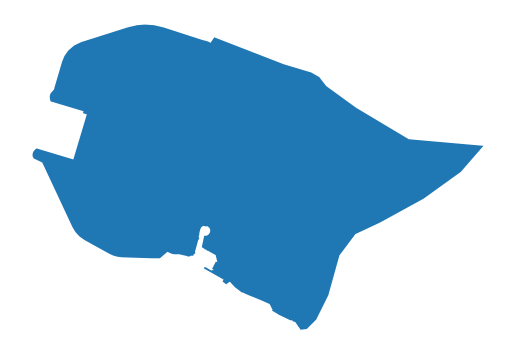

In [24]:
import osmnx as ox

boundary = ox.geocode_to_gdf('Санкт-Петербург, Василеостровский район')
boundary.plot().set_axis_off()

In [25]:
bc_tags = {
    'roads': {
      "highway": ["construction","crossing","living_street","motorway","motorway_link","motorway_junction","pedestrian","primary","primary_link","raceway","residential","road","secondary","secondary_link","services","tertiary","tertiary_link","track","trunk","trunk_link","turning_circle","turning_loop","unclassified",],
      "service": ["living_street", "emergency_access"]
    },
    'railways': {
      "railway": "rail"
    },
    'water': {
      'riverbank':True,
      'reservoir':True,
      'basin':True,
      'dock':True,
      'canal':True,
      'pond':True,
      'natural':['water','bay'],
      'waterway':['river','canal','ditch'],
      'landuse':'basin',
      'water': 'lake'
    }
}

In [ ]:
water = ox.features_from_polygon(boundary.union_all(), bc_tags['water'])
roads = ox.features_from_polygon(boundary.union_all(), bc_tags['roads'])
railways = ox.features_from_polygon(boundary.union_all(), bc_tags['railways'])

In [34]:
water = water[water.geom_type.isin(['Polygon', 'MultiPolygon', 'LineString', 'MultiLineString'])].copy()
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])].copy()
railways = railways[railways.geom_type.isin(['LineString', 'MultiLineString'])].copy()

In [40]:
crs = boundary.estimate_utm_crs()

for gdf in [water, roads, railways, boundary]:
  gdf.to_crs(crs, inplace=True)

### 1.2. Preprocessing input geometry

The step can be skipped if input geometries are already sorted as lines, polygons and boundary.

In [41]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

lines, polygons = preprocess_urban_objects(roads, railways, water)

2025-05-13 13:55:19.196 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:36 - Checking roads schema
2025-05-13 13:55:19.229 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:42 - Checking railways schema
2025-05-13 13:55:19.244 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:48 - Checking water schema


### 1.3. Cutting urban blocks

In [43]:
blocks = cut_urban_blocks(boundary, lines, polygons)

2025-05-13 13:55:28.163 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:20 - Checking boundaries schema
2025-05-13 13:55:28.174 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:24 - Checking line objects schema
2025-05-13 13:55:28.196 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:30 - Checking polygon objects schema
2025-05-13 13:55:28.212 | INFO     | blocksnet.blocks.cutting.processing.core:_exclude_polygons:45 - Excluding polygon objects from blocks
2025-05-13 13:55:28.731 | INFO     | blocksnet.blocks.cutting.processing.core:_get_enclosures:51 - Setting up enclosures
2025-05-13 13:55:28.774 | INFO     | blocksnet.blocks.cutting.processing.core:_fill_holes:68 - Filling holes inside the blocks
2025-05-13 13:55:28.806 | INFO     | blocksnet.blocks.cutting.processing.core:_filter_overlapping:78 - Filtering overlapping geometries
2025-05-13 13:55:28.869 | SUCCESS  | blocksnet.blocks.cutting.processing.core:cut_urban_blocks:119 - Blocks are succ

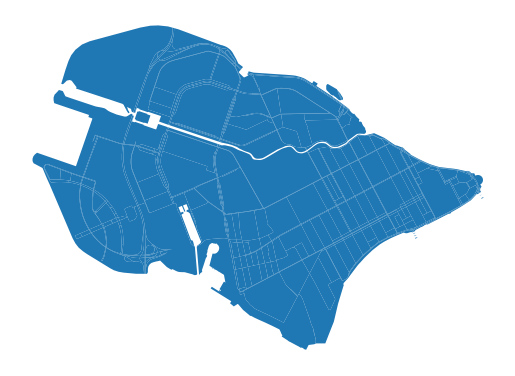

In [45]:
blocks.plot().set_axis_off()

## 2. Land use assignment